<h1> Laboratory work 1:  Text classification </h1>

Authors: Alexei Trutnev, Frolova Olga

## Exploratory data analysis

<h3> Dataset descriptions </h3>

The dataset <a href="https://www.kaggle.com/datasets/jp797498e/twitter-entity-sentiment-analysis/data" target="_blank">  Twitter Sentiment Analysis </a> is used.

This is an entity-level sentiment analysis dataset of twitter. Given a message and an entity, the task is to judge the sentiment of the message about the entity. There are three classes in this dataset: Positive, Negative and Neutral. We regard messages that are not relevant to the entity (i.e. Irrelevant) as Neutral.


In [1]:
from pathlib import Path

from src.preprocessing import (load_dataset,
                               set_seed,
                               remove_stop_words,
                               remove_special_characters,
                               removing_digits,
                               convert_to_lowercase,
                               remove_extra_spaces,
                               normalization_text,
                               tokenize_word
                               )
from src.visualization import distribution_chart, sentiment_distribution_chart, generate_sentiment_wordclouds

set_seed()

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/alexgiving/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/alexgiving/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
train_path = Path('data/twitter_training.csv')

In [3]:
df = load_dataset(train_path)

In [4]:
df.head(10)

,id,entity,sentiment,content
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
5,2401,Borderlands,Positive,im getting into borderlands and i can murder y...
6,2402,Borderlands,Positive,So I spent a few hours making something for fu...
7,2402,Borderlands,Positive,So I spent a couple of hours doing something f...
8,2402,Borderlands,Positive,So I spent a few hours doing something for fun...
9,2402,Borderlands,Positive,So I spent a few hours making something for fu...


### Check the empty and irrelevant data

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         74682 non-null  int64 
 1   entity     74682 non-null  object
 2   sentiment  74682 non-null  object
 3   content    73996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


Our dataset has empty `content` samples

In [6]:
df.dropna(inplace=True)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 73996 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         73996 non-null  int64 
 1   entity     73996 non-null  object
 2   sentiment  73996 non-null  object
 3   content    73996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.8+ MB


### Сheck duplication

In [10]:
print(f'Number of duplicates in the dataset: {df.duplicated().sum()}')

Number of duplicates in the dataset: 2340


In [11]:
# remove duplicates
df.drop_duplicates(inplace=True)

In [12]:
print(f'After remove duplicates, number of duplicates in the dataset: {df.duplicated().sum()}')

After remove duplicates, number of duplicates in the dataset: 0


### Distribution of sentiment

In [14]:
sentiment_counts = df['sentiment'].value_counts()
sentiment_counts

sentiment
Negative      21698
Positive      19713
Neutral       17708
Irrelevant    12537
Name: count, dtype: int64

/var/folders/87/3cnclgy53jd11fkzc4qp7mlc0000gn/T/ipykernel_13952/3713511204.py:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  distribution_chart(sentiment_counts,'sentiment').show()


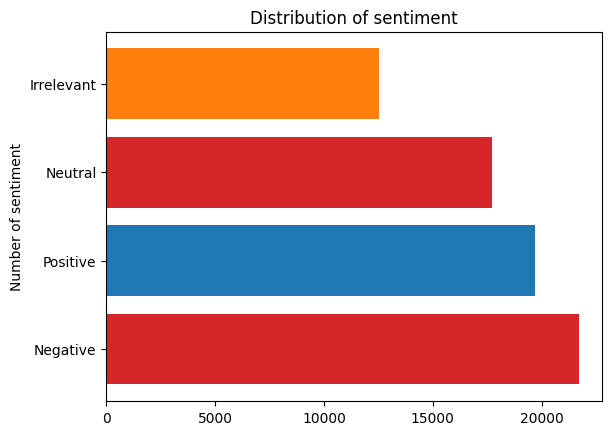

In [15]:
distribution_chart(sentiment_counts,'sentiment').show()

### Distribution of entity

In [16]:
entity = df['entity'].value_counts()

/var/folders/87/3cnclgy53jd11fkzc4qp7mlc0000gn/T/ipykernel_13952/3563687501.py:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  distribution_chart(entity, 'entity').show()


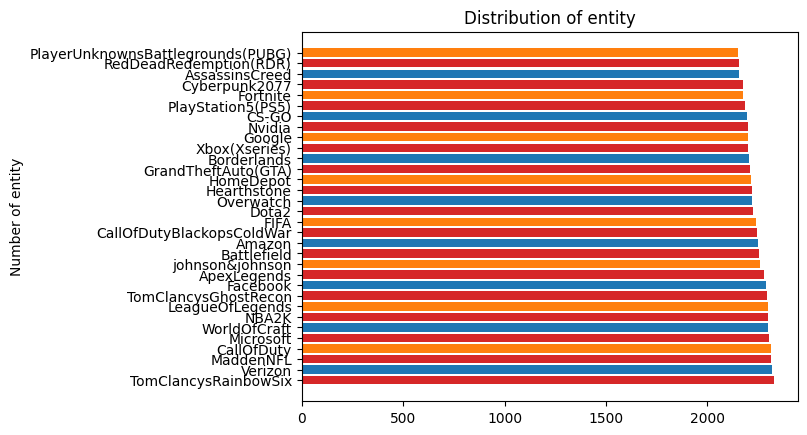

In [17]:
distribution_chart(entity, 'entity').show()

### Distribution of sentiment by entity

/var/folders/87/3cnclgy53jd11fkzc4qp7mlc0000gn/T/ipykernel_13952/621010469.py:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  sentiment_distribution_chart(df, 'entity', 'sentiment').show()


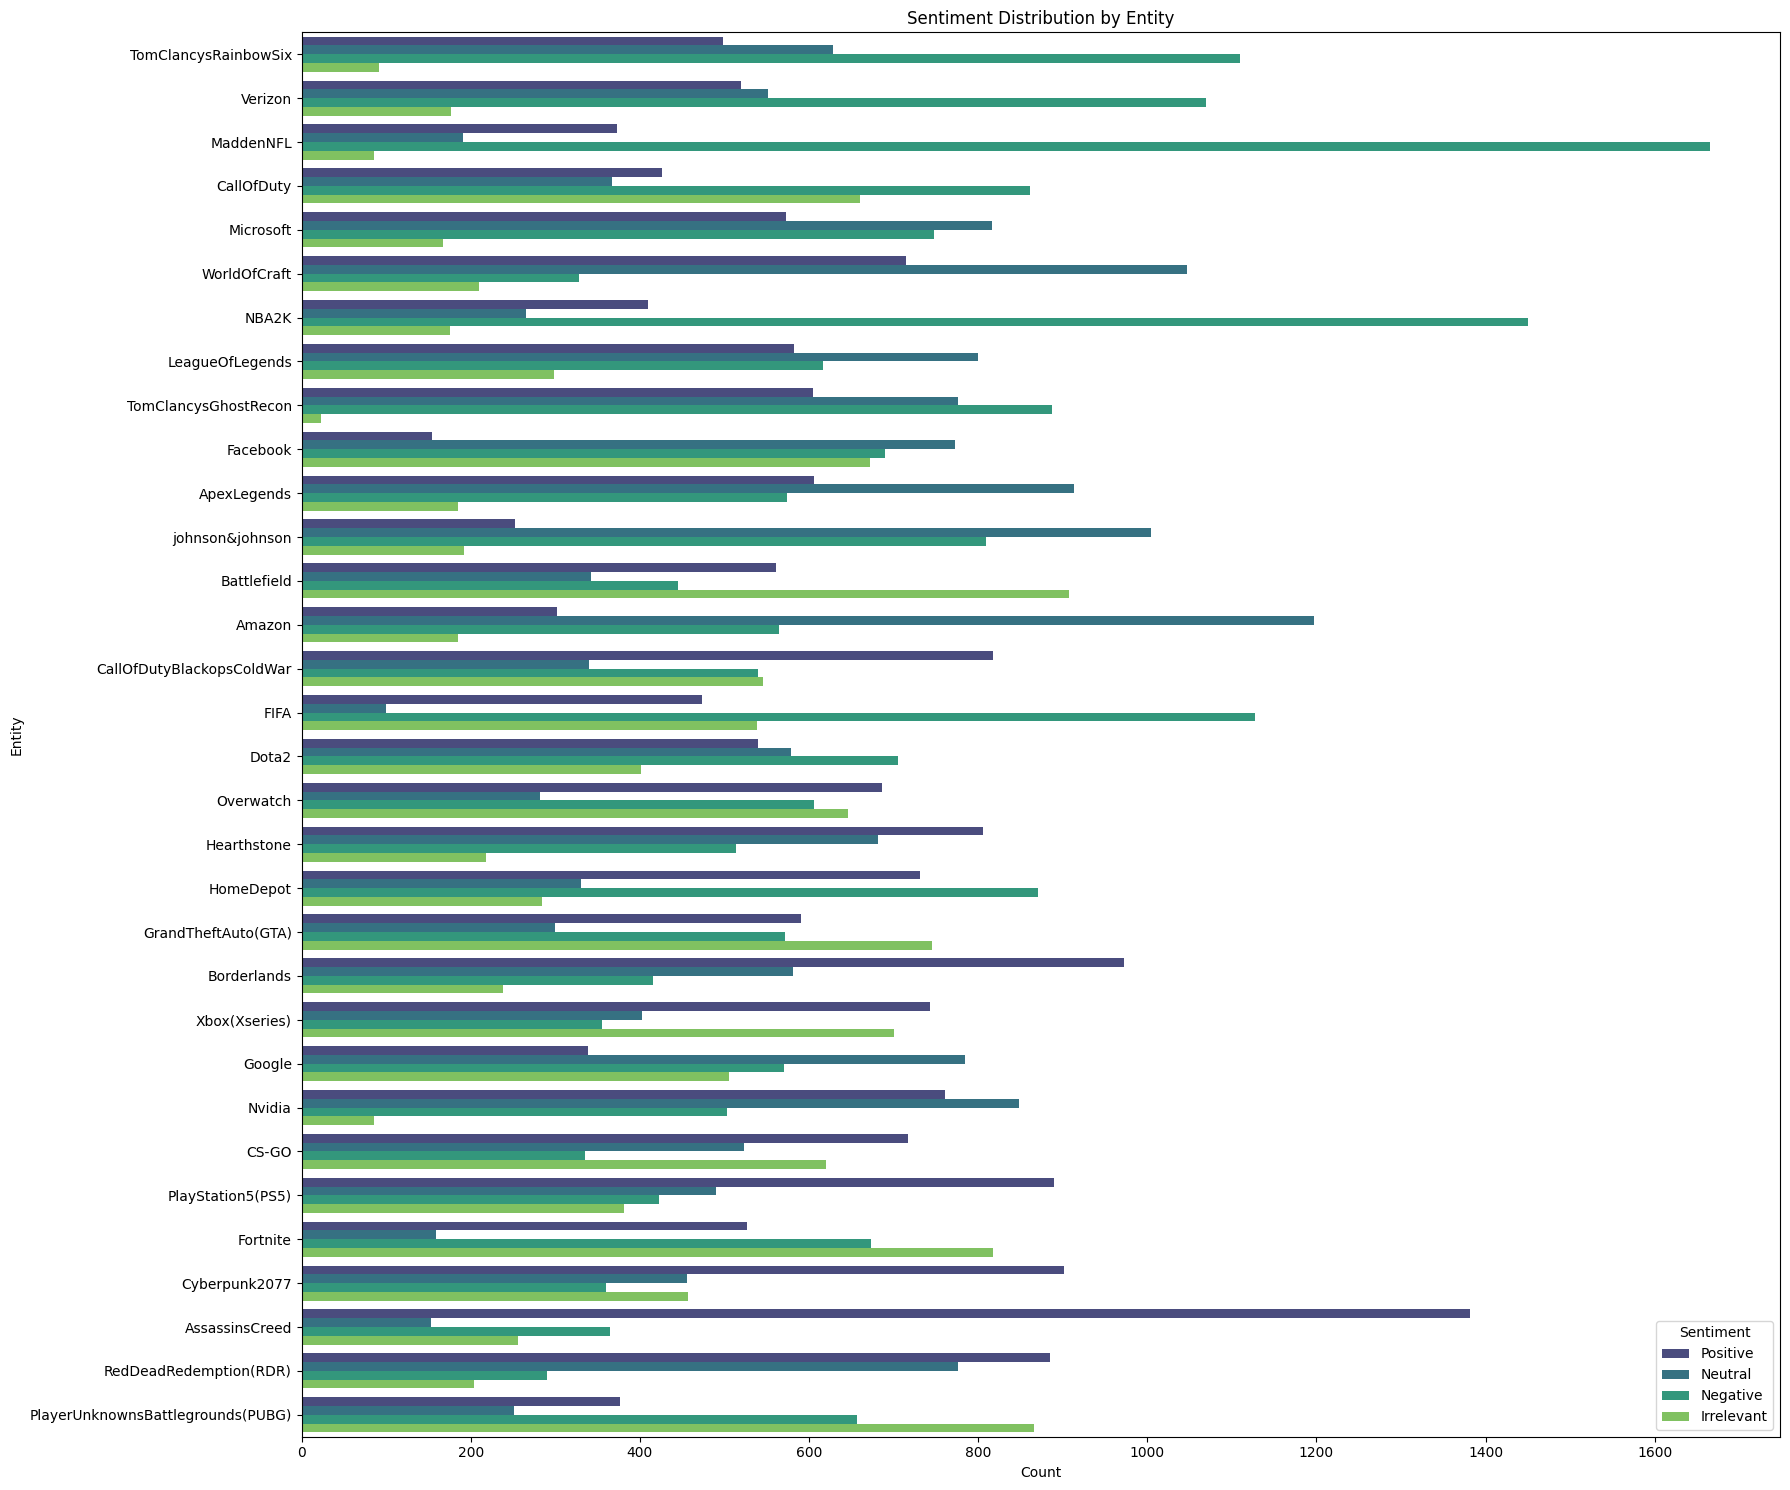

In [18]:
sentiment_distribution_chart(df, 'entity', 'sentiment').show()

### Word Cloud for each group sentiment 

/var/folders/87/3cnclgy53jd11fkzc4qp7mlc0000gn/T/ipykernel_13952/4027139701.py:4: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  sentiments=['Positive', 'Negative', 'Neutral', 'Irrelevant']).show()


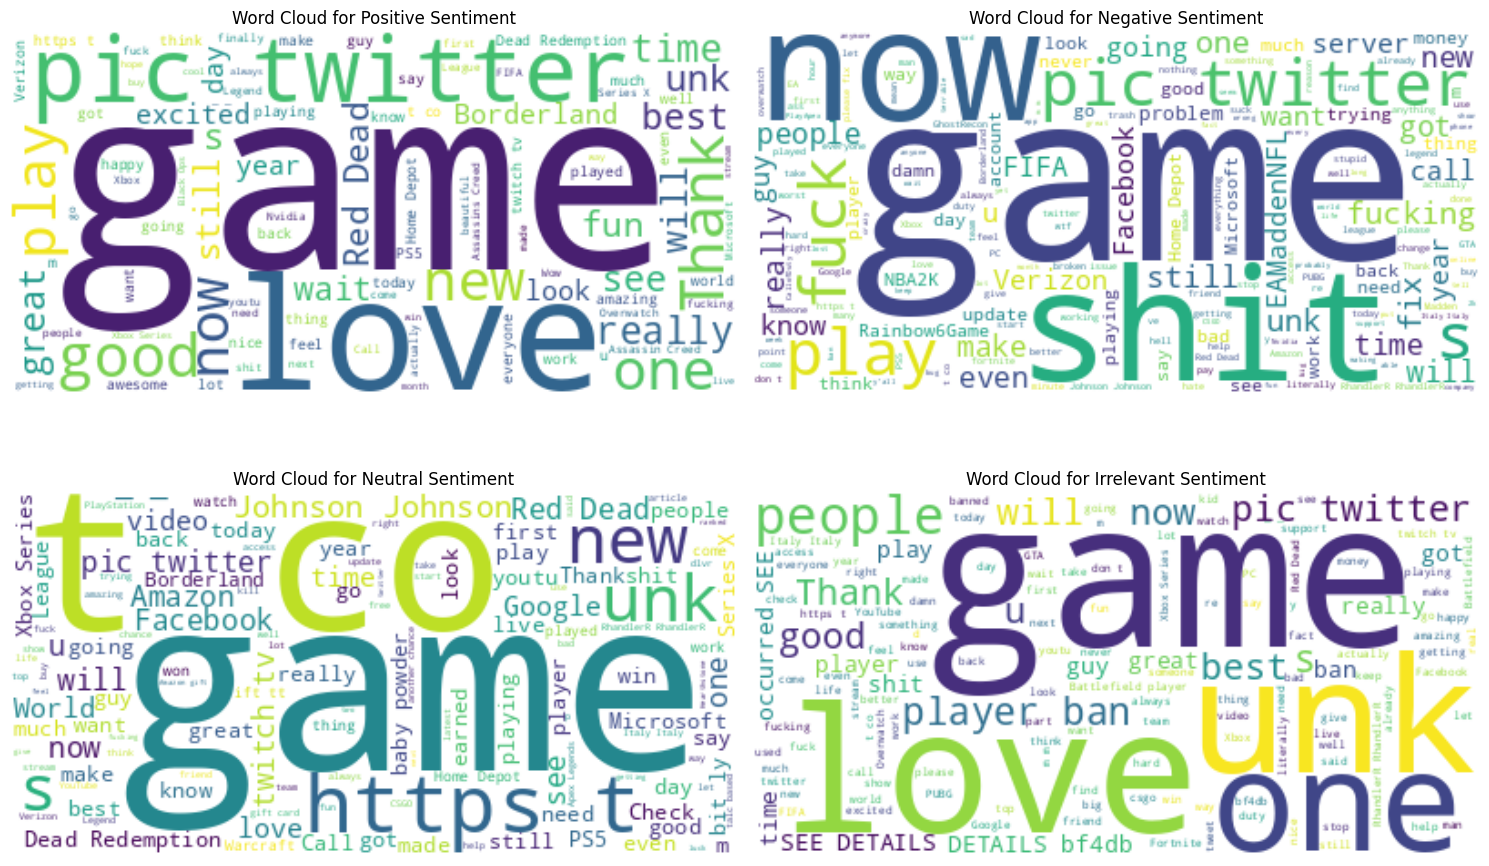

In [19]:
generate_sentiment_wordclouds(data=df,
                              sentiment_col='sentiment',
                              text_col='content',
                              sentiments=['Positive', 'Negative', 'Neutral', 'Irrelevant']).show()

### Data preprocessing

In [20]:
# remove stop words
df['content'] = df['content'].apply(remove_stop_words)
# remove special characters
df['content']= df['content'].apply(remove_special_characters)
# remove digits
df['content']= df['content'].apply(removing_digits)
# convert text to lowercase
df['content']= df['content'].apply(convert_to_lowercase)
# remove extra space
df['content']= df['content'].apply(remove_extra_spaces)

In [22]:
df = df[df['content'] != '']

In [24]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df['sentiment'] = label_encoder.fit_transform(df['sentiment'])

In [25]:
# Different variant normalization data: 'stemming', 'lemmatization', 'combo' (lemmatization + stemming)

df['content_lemma'] = df['content'].apply(lambda text: normalization_text('lemmatization', text))
df['content_stemming'] = df['content'].apply(lambda text: normalization_text('stemming', text))
df['content_combo'] = df['content'].apply(lambda text: normalization_text('combo', text))

## Prepare result dict

In [27]:
results = {}

## Subset formation


In [28]:
import pandas as pd
from typing import Optional


def get_subset(dataset: pd.DataFrame, n_samples: int, random_state: Optional[int] = None) -> pd.DataFrame:
    return dataset.sample(n=n_samples, random_state=random_state)


In [29]:
df_sub = get_subset(df, n_samples = 100, random_state = 42)

### Embeddings

In [30]:
from sklearn.model_selection import train_test_split
from functools import partial

train_test_split = partial(train_test_split, test_size=0.2, random_state=42)

# We will have 4 variants for analysis

X_train, X_test, y_train, y_test = train_test_split(df_sub['content'], df_sub['sentiment'])
X_train_lemma, X_test_lemma, y_train_lemma, y_test_lemma = train_test_split(df_sub['content_lemma'], df_sub['sentiment'])
X_train_stemming, X_test_stemming, y_train_stemming, y_test_stemming = train_test_split(df_sub['content_stemming'], df_sub['sentiment'])
X_train_combo, X_test_combo, y_train_combo, y_test_combo = train_test_split(df_sub['content_combo'], df_sub['sentiment'])


X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [31]:
from typing import Any, Dict
import numpy as np

from src.classification.classical_ml import ClassicClassification, ClassicClassificationType
from src.classification.quality import estimate_quality
from src.vectorizer import Vectorizer, VectorizerType


def dump_dict(dict: Dict[str, Any], indent: int = 2, precision: int = 2) -> str:
    string = ''
    for key, value in dict.items():

        if isinstance(value, np.ndarray):
            value = value.tolist()
        if isinstance(value, list):
            value = [round(val, precision) for val in value]
        else:
            value = round(value, precision)

        string += ' '* indent + f'{key}: {value}\n'
    return string


data_processing_map = {
    'original': (X_train, X_test, y_train, y_test),
    'lemmatization': (X_train_lemma, X_test_lemma, y_train_lemma, y_test_lemma),
    'stemming': (X_train_stemming, X_test_stemming, y_train_stemming, y_test_stemming),
    'combination': (X_train_combo, X_test_combo, y_train_combo, y_test_combo),
}

vectorizers = (
    VectorizerType.FAST_TEXT,
    VectorizerType.W2V,
    VectorizerType.ONE_HOT,
    VectorizerType.TF_IDF,
)
classifications = (
    ClassicClassificationType.SVC,
    ClassicClassificationType.DECISION_TREE,
    ClassicClassificationType.RANDOM_FOREST,
    ClassicClassificationType.K_NEIGHBORS,
    )

for preprocessing_name, (X_train, X_test, y_train, y_test) in data_processing_map.items():

    for vectorizer_type in vectorizers:
        vectorizer = Vectorizer(vectorizer_type)
        vectorizer.fit(X_train)

        X_train_vec = np.array(vectorizer.transform(X_train))
        X_test_vec = np.array(vectorizer.transform(X_test))

        for classification_type in classifications:
            classificator = ClassicClassification(classification_type)
            classificator.fit(X_train_vec, y_train)

            y_pred = classificator.predict(X_test_vec)

            results = estimate_quality(y_test, y_pred)
            print(f'Preprocessing: {preprocessing_name}, Vectorizer: {vectorizer_type.name}, Classificator: {classification_type.name}')
            print(dump_dict(results, indent=4))

Preprocessing: original, Vectorizer: FAST_TEXT, Classificator: SVC
    accuracy: 0.4
    per_class_accuracy: [0.0, 1.0, 0.0, 0.0]
    f1: 0.4
    per_class_f1: [0.0, 0.59, 0.0, 0.0]

Preprocessing: original, Vectorizer: FAST_TEXT, Classificator: DECISION_TREE
    accuracy: 0.3
    per_class_accuracy: [0.5, 0.25, 0.29, 0.33]
    f1: 0.3
    per_class_f1: [0.29, 0.29, 0.33, 0.29]

Preprocessing: original, Vectorizer: FAST_TEXT, Classificator: RANDOM_FOREST
    accuracy: 0.35
    per_class_accuracy: [1.0, 0.38, 0.14, 0.33]
    f1: 0.35
    per_class_f1: [0.67, 0.4, 0.25, 0.18]

Preprocessing: original, Vectorizer: FAST_TEXT, Classificator: K_NEIGHBORS
    accuracy: 0.55
    per_class_accuracy: [1.0, 1.0, 0.14, 0.0]
    f1: 0.55
    per_class_f1: [0.8, 0.73, 0.25, 0.0]

Preprocessing: original, Vectorizer: W2V, Classificator: SVC
    accuracy: 0.4
    per_class_accuracy: [0.0, 1.0, 0.0, 0.0]
    f1: 0.4
    per_class_f1: [0.0, 0.57, 0.0, 0.0]

Preprocessing: original, Vectorizer: W2V, Clas

## GridSearch

In [ ]:
from src.classification.classical_ml import ClassicClassification, ClassicClassificationType
from src.classification.quality import estimate_quality

### SVC

In [31]:
params = {
    'gamma': [2, 4],
    'C': [1, 0.5], 
}

classificator = ClassicClassification(ClassicClassificationType.SVC)
classificator.grid_search(X_train_vec, y_train, param_grid=params)

y_pred = classificator.predict(X_test_vec)

estimate_quality(y_test, y_pred)

Best parameters found:  {'C': 1, 'gamma': 2}


{'accuracy': 0.305,
 'per_class_accuracy': array([0.        , 0.9516129 , 0.03773585, 0.        ]),
 'f1': 0.305,
 'per_class_f1': array([0.        , 0.46456693, 0.06779661, 0.        ])}

### Decision tree

In [32]:
params = {
    'max_depth': [5, 10],
    'criterion': ['entropy', 'gini'], 
}

classificator = ClassicClassification(ClassicClassificationType.DECISION_TREE)
classificator.grid_search(X_train_vec, y_train, param_grid=params)

y_pred = classificator.predict(X_test_vec)

estimate_quality(y_test, y_pred)

Best parameters found:  {'criterion': 'gini', 'max_depth': 10}


{'accuracy': 0.345,
 'per_class_accuracy': array([0.10810811, 0.9516129 , 0.03773585, 0.08333333]),
 'f1': 0.345,
 'per_class_f1': array([0.18604651, 0.48962656, 0.07272727, 0.13114754])}

### Random Forest

In [33]:
params = {
    'n_estimators': [50, 100],
    'criterion': ['entropy', 'gini'], 
    'max_depth': [5, 10]
}

classificator = ClassicClassification(ClassicClassificationType.RANDOM_FOREST)
classificator.grid_search(X_train_vec, y_train, param_grid=params)

y_pred = classificator.predict(X_test_vec)

estimate_quality(y_test, y_pred)

Best parameters found:  {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 50}


{'accuracy': 0.31,
 'per_class_accuracy': array([0., 1., 0., 0.]),
 'f1': 0.31,
 'per_class_f1': array([0.        , 0.47328244, 0.        , 0.        ])}

### k_neighbors

In [34]:
params = {
    'n_neighbors': [5, 10],
    'weights': ['uniform', 'distance'], 
    'algorithm': ['ball_tree', 'kd_tree', 'auto']
}

classificator = ClassicClassification(ClassicClassificationType.K_NEIGHBORS)
classificator.grid_search(X_train_vec, y_train, param_grid=params)

y_pred = classificator.predict(X_test_vec)

estimate_quality(y_test, y_pred)

Best parameters found:  {'algorithm': 'ball_tree', 'n_neighbors': 5, 'weights': 'distance'}


{'accuracy': 0.325,
 'per_class_accuracy': array([0.02702703, 0.80645161, 0.09433962, 0.1875    ]),
 'f1': 0.325,
 'per_class_f1': array([0.05      , 0.45248869, 0.16129032, 0.23376623])}

## Classification

In [35]:
from src.classification.classical_ml import ClassicClassification, ClassicClassificationType
from src.classification.quality import estimate_quality

classificator = ClassicClassification(ClassicClassificationType.DECISION_TREE)
classificator.fit(X_train_vec, y_train)

y_pred = classificator.predict(X_test_vec)

estimate_quality(y_test, y_pred)

{'accuracy': 0.345,
 'per_class_accuracy': array([0.05405405, 1.        , 0.03773585, 0.0625    ]),
 'f1': 0.345,
 'per_class_f1': array([0.1025641 , 0.49206349, 0.07272727, 0.11111111])}